# CS7290 Applied Bayesian Machine Learning Project 
# Author: Mian Zhang

## 1. Introduction

Suppose there is a company called ABC, and one of their products is a jacket. In order to promote and advertise the jacket, they have many marketing strategies including online and offline marketing. Online marketing consists of Amazon search, youtube and facebook ads, etc. Offline marketing consists of cinema ads, TV ads, radio ads, etc. Their goal is to discover the impact of various marketing channels on sales of the jacket. In this way, they can spend more money on channels that are more effective. 

This is a collaborative project between Altdeep and Artefact(A digital marketing company), and me with three other students joined this project. Artefact staff have already established a quite completed flow of this project, from DAG to model building. Therefore, supervised by Artefact staff, seperated tasks were assigned to each of us in order to provide some improvements for their completed work. That is to say, each of us got tasks that were individual to others. Therefore, according to tasks that I received, the final goal mentioned above is not likely to be present in this notebook. And I will try my best to combine all of my tasks into a single story.

## 2. Dataset

Although due to the Non-disclosure Agreement with Artefact, the original dataset file is not allowed to be present in this notebook, the definition of each variables in the dataset can be introduced.

External Shocks: Situations that cannot be defined or controlled by human, including COVID and holidays.

Price: The price of the jacket

Distribution: The number of available stores selling the jacket and the number of available jackets sold in available stores.

Marketing Offline: Impression generated by all channels of offline marketing, including video, TV, cinema, etc.

Promotion: units sold by promotion

Competition: the sales of the jacket sold by competition companies.

Other Products: the sales of other products sold be the same company that selling the jacket.

Marketing Online: Impression generated by all channels of online marketing, including Amazon, Youtube, Facebook, etc.

TGT: the sales of the jacket.

## 3. How to deal with cyclicity in directed graph? (Task 1)

Artefact staff have already built a directed graph based on business knowledge and statistical test. However, there are two cycles in the graph, which are shown as following:

In [1]:
%%html

# directed graph
<img src="./pictures/directed graph.png">

# cycles
<img src="./pictures/cycle 1.png">
<img src="./pictures/cycle 2.png">

We know that the final probabilistic model should be built based on a directed acyclic graph(DAG). So how to remove cycles? 

One of the solutions is Topological Sorting, which is a graph traversal in which each node v is visited only after all its dependencies are visited. The application of Topological Sorting is as following:

Step 1: Remove all lines among these nodes. Assume that there are only green blocks and no lines in each graph.

Step 2: Compare the degree of freedom of each node. That is to say, count incoming lines for each node. In the first graph, Offline Marketing is 1, Online Marketing is 3, and Competition is 3, so Offline Marketing has the highest degree of freedom. Same for the second graph.



Step 3: Check if there are original lines violating the topological sorting rules. For the first graph, according to Topological Sorting, the direction between Offline and Online Marketing should be Offline to Online, and thus the grey line should be deleted and the pink line should be the correct one. Same for the second graph. Besides, for Online Marketing and Competition in the first graph, since the degree of freedom of one node is not higher than another, the original line also makes sense. Same for Online Marketing and Other Products in the second graph.


In [2]:
%%html

# Topological Sorting Steps
<img src="./pictures/ts.png">

## 4. What's the right metric to use for model quality control?(Task 2)

Now that we have a real DAG as well as the original model provided by Artefact, how can we know whether one model is better than another? The table below shows the advantages and disadvantages of some common evaluation metrics. In brief, Widely Applicable Information Criteria(WAIC) and Leave-one-out cross-validation (LOO) is going to be used, because they can show a balance between the goodness of fit of models and the model complexity.

In [3]:
%%html

# metrics comparison
<img src="./pictures/metrics.png">

## 5. What's the right metric to use for model quality control?(Task 3)

### 5.1 Original Model

The original model defined variables as Normal distribution with self-defined mu and sigma(Section 5.1.4), which is based on domain knowledge. It also defined coefficients as Standard Normal distribution and Half Normal Distribution(Section 5.1.4), which are weakly informative priors. The posterior predictive check result is not bad(Section 5.1.8), but the sales data simulated from prior predictive check is not similar to the original data(Section 5.1.5). For example, the minimum and maximum value of simulated data is more extreme than original data.

For the original model, we can see from the results(Section 5.1.7) below that the convergence is perfect, since almost all values of r-hat are close to 1. For WAIC and LOO(Section 5.1.9), since the absolute value doesn't have significance, we will use them later when we have modified model.

#### 5.1.1 Import Libraries

In [57]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 20, 10

import pydot
import seaborn as sns
from matplotlib.collections import LineCollection
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2_contingency
from pgmpy.models import BayesianModel
from pgmpy.estimators.CITests import cressie_read
import arviz as az
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

# Pre-processing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#### 5.1.2 Data Cleaning and Feature Engineering

In [58]:
def standard_transform(df, cols):
    mean_dict = {}
    std_dict = {}
    df_transformed = pd.DataFrame()
    for col in cols:
        col_mean = df[col].mean()
        col_std = df[col].std()
        df_transformed[col] = ((df[col] - col_mean) / col_std)
        mean_dict[col] = col_mean
        std_dict[col] = col_std
    return df_transformed, mean_dict, std_dict

In [59]:
# helper functions
def apply_mean_center(x):
    mu = np.nanmean(x)
    xm = x / mu
    return xm, mu


def mean_center_transform(df, cols):
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc


def mean_center_transform_excl0(df, cols):
    df_new = pd.DataFrame()
    sc = {}
    df = df.replace(0, np.nan)
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    df_new = df_new.replace(np.nan, 0)
    return df_new, sc


# Outlier distribution
def outlier_distribution(data):
    numeric_var_names = [
        key for key in dict(data.dtypes)
        if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']
    ]
    num = data[numeric_var_names]

    def var_summary(x):
        return pd.Series([
            x.count(),
            x.isnull().sum(),
            x.sum(),
            x.mean(),
            x.median(),
            x.std(),
            x.var(),
            x.min(),
            x.dropna().quantile(0.01),
            x.dropna().quantile(0.05),
            x.dropna().quantile(0.10),
            x.dropna().quantile(0.25),
            x.dropna().quantile(0.50),
            x.dropna().quantile(0.75),
            x.dropna().quantile(0.90),
            x.dropna().quantile(0.95),
            x.dropna().quantile(0.99),
            x.max()
        ],
                         index=[
                             'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD',
                             'VAR', 'MIN', 'P1', 'P5', 'P10', 'P25', 'P50',
                             'P75', 'P90', 'P95', 'P99', 'MAX'
                         ])

    num_summary = num.apply(lambda x: var_summary(x)).T
    return num_summary


def apply_adstock(df, col, L=8, P=3, D=1.8):
    """
    params:
    x: original media variable - column name
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    """
    x = np.array(df[col])
    x = np.append(np.zeros(L - 1), x)
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l - P)**2)
        weights[L - 1 - l] = weight
    adstocked_x = []
    for i in range(L - 1, len(x)):
        x_array = x[i - L + 1:i + 1]
        xi = sum(x_array * weights) / sum(weights)
        adstocked_x.append(xi)
    return np.array(adstocked_x)


def saturation(x, s, k):
    return 1 / (1 + (x / k)**(-s))


def apply_transform(df, col, mean_transform_lkp):
    return np.log1p(df[col]) / mean_transform_lkp[col]


def geometric_adstock(x, theta, alpha, L=3):
    w = tt.as_tensor_variable(
        [tt.power(alpha, tt.power(i - theta, 2)) for i in range(L)])
    xx = tt.stack(
        [tt.concatenate([tt.zeros(i), x[:x.shape[0] - i]]) for i in range(L)])
    return tt.dot(w / tt.sum(w), xx)


def logistic_function(x_t, mu=0.1):
    return (1 * (1 - np.exp(-mu * x_t))) / (1 + np.exp(-mu * x_t))


def logistic(l):
    return 1 / (1 + tt.exp(-l))


def scale_transform(df, cols, range_min=0, range_max=1):
    min_dict = {}
    max_dict = {}
    df_transformed = pd.DataFrame()
    for col in cols:
        col_min = df[col].min()
        col_max = df[col].max()
        df_transformed[col] = (((df[col] - col_min) / (col_max - col_min)) *
                               (range_max - range_min)) + range_min
        min_dict[col] = col_min
        max_dict[col] = col_max
    return df_transformed, min_dict, max_dict


def revert_scale_transform(df_transformed,
                           cols,
                           min_lookup,
                           max_lookup,
                           range_min=0,
                           range_max=1):
    df_actual = pd.DataFrame()
    for col in cols:
        if 'TGT' in col:
            col_min = min_lookup['TGT']
            col_max = max_lookup['TGT']
        else:
            col_min = min_lookup[col]
            col_max = max_lookup[col]
        df_actual[col] = (((df_transformed[col] - range_min) /
                           (range_max - range_min)) *
                          (col_max - col_min)) + col_min
    return df_actual

In [60]:
# According to the Non-disclosure Agreemen, dataset is not allowed to be present here.

df_init['week_id'] = pd.to_datetime(df_init['week_id'],
                                    format='%Y-%m-%d').dt.date
df_init.set_index(['core', 'npd', 'competition', 'week_id'], inplace=True)
week_index = df_init.reset_index()['week_id']

In [61]:
COLS = [
    'TGT', 'MARKETING_ONLINE', 'MARKETING_OFFLINE', 'MARKETING_ONLINE_SP',
    'MARKETING_OFFLINE_SP', 'PROMO', 'PRICE', 'DISTRIBUTION', 'OTHER_PRODUCTS',
    'COMPETITION', 'EXT_SHOCKS'
]
COLS_DICT = dict(zip(COLS, [[]] * len(COLS)))
COLS_DICT['MARKETING_ONLINE'] = [
    x for x in df_init.columns if ('core' in x)
    & (('impressions' in x) | ('cpp' in x) | ('spend' in x))
    & (x.split('_')[1].lower() not in ['cinema', 'tv', 'bvod', 'ooh', 'radio'])
]
existing = list(COLS_DICT['MARKETING_ONLINE'])

COLS_DICT['MARKETING_OFFLINE'] = [
    x for x in df_init.columns if ('core' in x)
    & (('impressions' in x) | ('cpp' in x) | ('spend' in x))
    & (x.split('_')[1].lower() in ['cinema', 'tv', 'bvod', 'ooh', 'radio'])
]
existing.extend(list(COLS_DICT['MARKETING_OFFLINE']))

COLS_DICT['PROMO'] = [
    x for x in df_init.columns if ('core' in x)
    & ('promo' in x)
]
existing.extend(list(COLS_DICT['PROMO']))

COLS_DICT['PRICE'] = [
    x for x in df_init.columns if ('core' in x)
    & ('price' in x)
]
existing.extend(list(COLS_DICT['PRICE']))

COLS_DICT['TGT'] = [
    x for x in df_init.columns if (x not in existing)
    & ('core' in x)
    & ('sales' in x)
]
existing.extend(list(COLS_DICT['TGT']))

COLS_DICT['DISTRIBUTION'] = [
    x for x in df_init.columns if (x not in existing)
    & ('core' in x)
]
existing.extend(list(COLS_DICT['DISTRIBUTION']))

COLS_DICT['OTHER_PRODUCTS'] = [
    x for x in df_init.columns if (x not in existing)
    & ('npd' in x)
    | (x.split('_')[0].lower() in ['em', 'candles', 'reeds'])
]
existing.extend(list(COLS_DICT['OTHER_PRODUCTS']))

COLS_DICT['COMPETITION'] = [
    x for x in df_init.columns if (x not in existing)
    & ('comp' in x)
]
existing.extend(list(COLS_DICT['COMPETITION']))

COLS_DICT['EXT_SHOCKS'] = [x for x in df_init.columns if (x not in existing)]
existing.extend(list(COLS_DICT['EXT_SHOCKS']))

assert len(np.unique(existing)) == len(np.unique(df_init.columns))

In [62]:
# Create a dataframe: first iteration - impressions for media, units for sales
df_proc = df_init.copy()

COLS_DICT_SUBSET = dict()

# sales-based
COLS_DICT_SUBSET['TGT'] = [
    x for x in COLS_DICT['TGT'] if ('units' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['PROMO'] = [
    x for x in COLS_DICT['PROMO'] if ('units' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['COMPETITION'] = [
    x for x in COLS_DICT['COMPETITION'] if ('units' in x) & ('sum' in x)
]

# media-based
COLS_DICT_SUBSET['MARKETING_ONLINE'] = [
    x for x in COLS_DICT['MARKETING_ONLINE']
    if ('impressions' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['MARKETING_ONLINE_SP'] = [
    x for x in COLS_DICT['MARKETING_ONLINE'] if ('spend' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['MARKETING_OFFLINE'] = [
    x for x in COLS_DICT['MARKETING_OFFLINE']
    if ('impressions' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['MARKETING_OFFLINE_SP'] = [
    x for x in COLS_DICT['MARKETING_OFFLINE'] if ('spend' in x) & ('sum' in x)
]
COLS_DICT_SUBSET['OTHER_PRODUCTS'] = [
    x for x in COLS_DICT['OTHER_PRODUCTS']
    if ('impressions' in x) & ('sum' in x)
]

# other
COLS_DICT_SUBSET['DISTRIBUTION'] = [
    x for x in COLS_DICT['DISTRIBUTION'] if ('sum' in x)
]
COLS_DICT_SUBSET['PRICE'] = COLS_DICT['PRICE']
COLS_DICT_SUBSET['seasonality_holidays'] = [
    x for x in COLS_DICT['EXT_SHOCKS'] if ('seasonality_holidays' in x)
]
COLS_DICT_SUBSET['covid_new_cases'] = [
    x for x in COLS_DICT['EXT_SHOCKS'] if ('new_cases' in x)
]

In [63]:
df_proc = df_proc.sort_values(by=['week_id']).reset_index(drop=True)

# Fillna with zero
df_proc = df_proc.fillna(0)

# Outlier capping
for col in df_proc.columns:
    percentiles = df_proc[col].quantile([0.01, 0.99]).values
    df_proc[col] = np.clip(df_proc[col], percentiles[0], percentiles[1])

# Media impressions
df_proc_media = df_proc[COLS_DICT_SUBSET['MARKETING_ONLINE'] +
                        COLS_DICT_SUBSET['MARKETING_OFFLINE']]

# mean center data
mean_dict_media = {}
for col in df_proc_media.columns:
    mean_dict_media[f"{col.lower()}_mean"] = df_proc_media[col].mean()

# Applying mean center transformation
df_transformed_media, transform_lookup_media = mean_center_transform_excl0(
    df_proc_media, df_proc_media.columns)

data = pd.DataFrame()
for (k, v) in COLS_DICT_SUBSET.items():
    if k == 'MARKETING_OFFLINE':
        data[k] = df_transformed_media[v].sum(axis=1)
    elif k == 'MARKETING_ONLINE':
        data[k] = df_proc_media[v].sum(axis=1)
    elif k == 'PRICE':
        data[k] = df_proc[v].median(axis=1)
    else:
        data[k] = df_proc[v].sum(axis=1)

data2 = pd.concat([
    data, df_transformed_media,
    df_proc[COLS_DICT_SUBSET['MARKETING_ONLINE_SP'] +
            COLS_DICT_SUBSET['MARKETING_OFFLINE_SP']]
],
                  axis=1)

# Adding absolute minimum for holidays to avoid -ve values before log transformation
data2['seasonality_holidays'] = data2['seasonality_holidays'] + abs(
    data2.seasonality_holidays.min())

# Log transformation
log_data2 = pd.DataFrame()
for col in data2.columns:
    log_data2[col] = np.log(data2[col] + 1)

# log_data2 = data2.copy()
# Applying mean center transformation
df_transformed, transform_lookup = mean_center_transform_excl0(
    log_data2, log_data2.columns)

# Storing final data mean and sigma
data_dict = {}
mean_dict = {}
sigma_dict = {}
for col in df_transformed.columns:
    data_dict[col.lower()] = df_transformed[col].values
    mean_dict[f"{col.lower()}_mean"] = df_transformed[col].mean()
    sigma_dict[f"{col.lower()}_sigma"] = df_transformed[col].std()

#### 5.1.3 Data Visualization

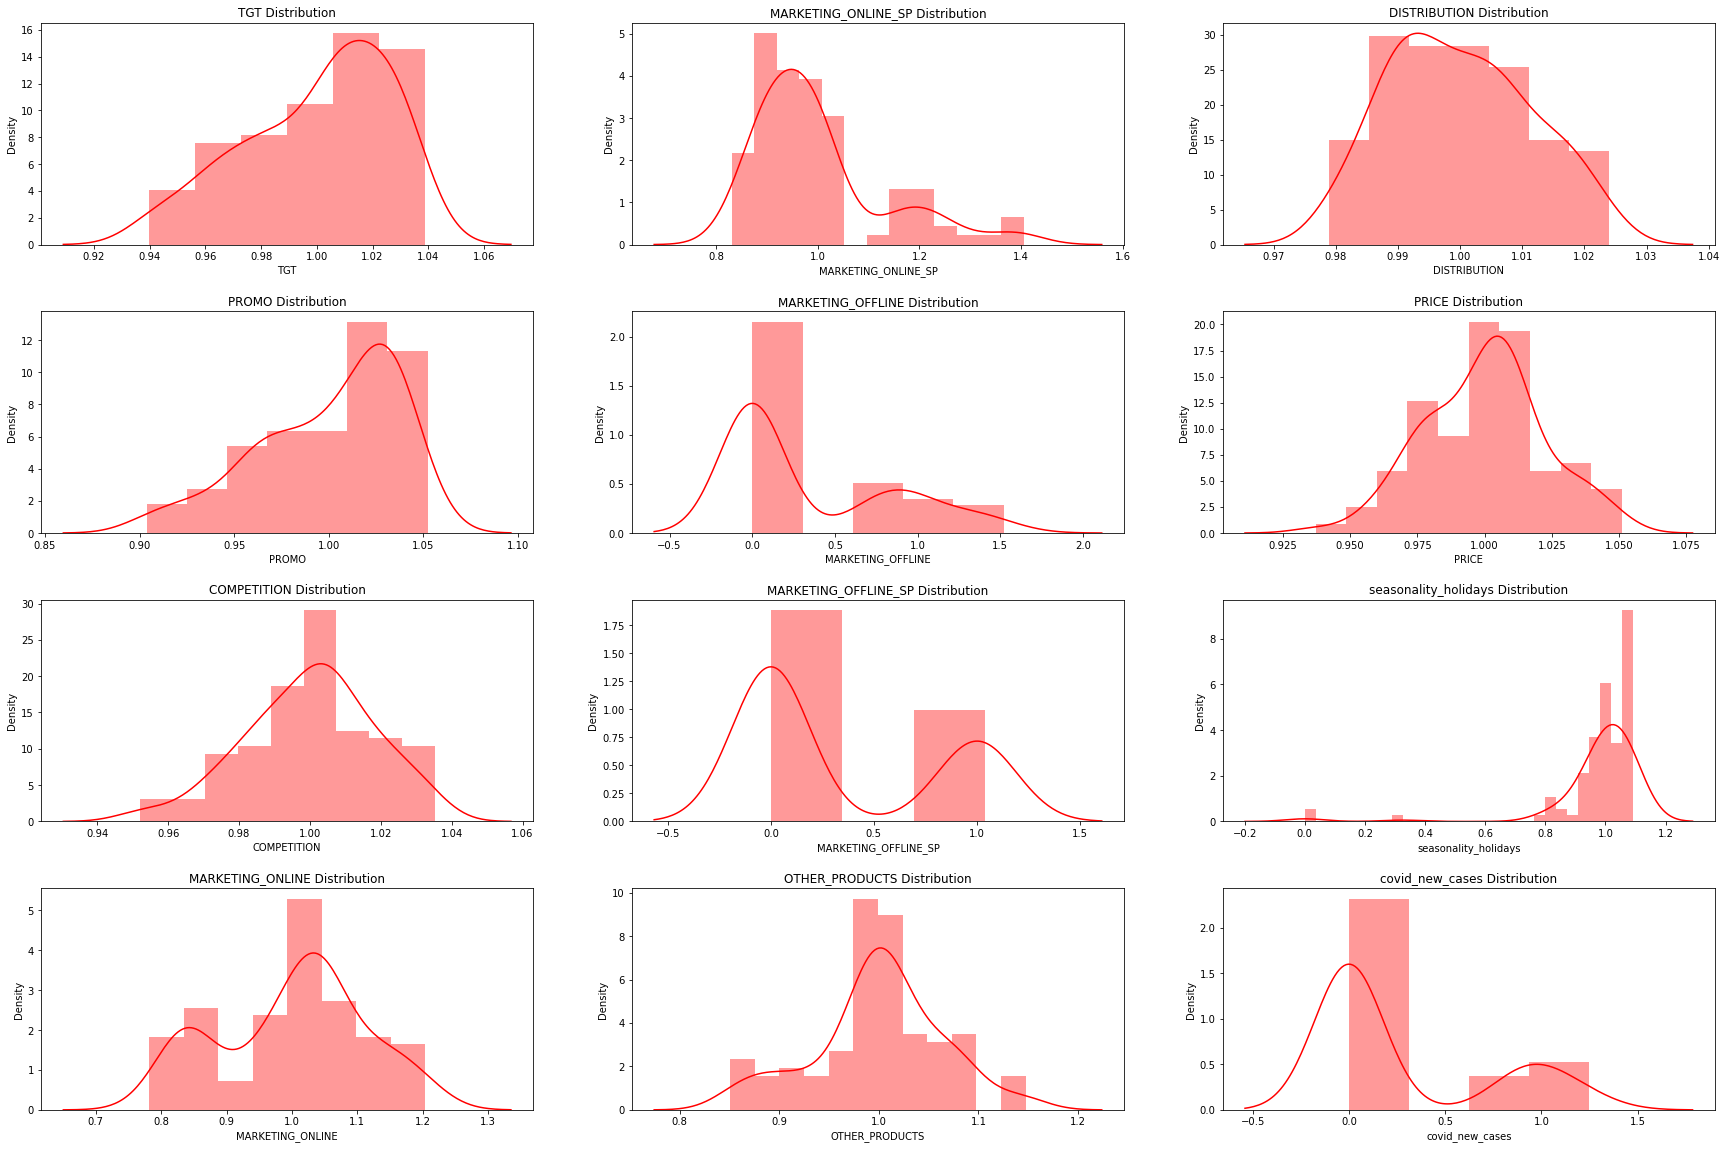

In [64]:
fig, ax = plt.subplots(4, 3, figsize=(30, 20))
i = 0
j = 0
k = 0
while i < 12:
    p = sns.distplot(df_transformed[df_transformed.columns[i]],
                     color="r",
                     kde=True,
                     ax=ax[j][k])
    p.set_title(df_transformed.columns[i] + ' Distribution')
    i += 1
    if j == 3:
        j = 0
        k += 1
    else:
        j += 1
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=None,
                    hspace=0.3)

#### 5.1.4 Build the Model

In [65]:
%%time

with pm.Model() as py_stan_dag2:

    ################################ Defining Mean & Sigma ################################
    len_df = len(data_dict['tgt'])
    seasonality_holidays_mean = mean_dict['seasonality_holidays_mean']
    covid_new_cases_mean = mean_dict['covid_new_cases_mean']
    seasonality_holidays_sigma = sigma_dict['seasonality_holidays_sigma']
    covid_new_cases_sigma = sigma_dict['covid_new_cases_sigma']
    price_mean = mean_dict['price_mean']
    price_sigma = sigma_dict['price_sigma']
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_offline_mean = mean_dict['marketing_offline_mean']
    promo_sigma = sigma_dict['promo_sigma']
    promo_mean = mean_dict['promo_mean']
    distribution_sigma = sigma_dict['distribution_sigma']
    distribution_mean = mean_dict['distribution_mean']
    competition_sigma = sigma_dict['competition_sigma']
    competition_mean = mean_dict['competition_mean']
    other_products_sigma = sigma_dict['other_products_sigma']
    other_products_mean = mean_dict['other_products_mean']
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    marketing_online_mean = mean_dict['marketing_online_mean']
    tgt_mean = mean_dict['tgt_mean']

    tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    ################################ Defining Beta's ################################
    BoundedNormal = pm.Bound(pm.Normal, upper=0)
    beta_price_to_promo = BoundedNormal('beta_price_to_promo', 0, 1)
    beta_seasonality_holidays_to_promo = pm.Normal(
        'beta_seasonality_holidays_to_promo', 0, 1)
    beta_covid_new_cases_to_promo = pm.Normal('beta_covid_new_cases_to_promo',
                                              0, 1)
    beta_offline_to_online = pm.HalfNormal('beta_offline_to_online', 1)
    beta_seasonality_holidays_to_online = BoundedNormal(
        'beta_seasonality_holidays_to_online', 0, 1)
    beta_covid_new_cases_to_online = BoundedNormal(
        'beta_covid_new_cases_to_online', 0, 1)
    beta_seasonality_holidays_to_distribution = pm.Normal(
        'beta_seasonality_holidays_to_distribution', 0, 1)
    beta_covid_new_cases_to_distribution = pm.Normal(
        'beta_covid_new_cases_to_distribution', 0, 1)
    beta_price_to_competition = pm.Normal('beta_price_to_competition', 0, 1)
    beta_seasonality_holidays_to_competition = pm.Normal(
        'beta_seasonality_holidays_to_competition', 0, 1)
    beta_covid_new_cases_to_competition = pm.Normal(
        'beta_covid_new_cases_to_competition', 0, 1)
    beta_promo_to_competition = BoundedNormal('beta_promo_to_competition', 0,
                                              1)
    beta_online_to_competition = BoundedNormal('beta_online_to_competition', 0,
                                               1)
    beta_distribution_to_competition = BoundedNormal(
        'beta_distribution_to_competition', 0, 1)
    beta_offline_to_competition = pm.Normal('beta_offline_to_competition', 0,
                                            1)
    beta_price_to_otherprod = pm.Normal('beta_price_to_otherprod', 0, 1)
    beta_seasonality_holidays_to_otherprod = pm.Normal(
        'beta_seasonality_holidays_to_otherprod', 0, 1)
    beta_covid_new_cases_to_otherprod = pm.Normal(
        'beta_covid_new_cases_to_otherprod', 0, 1)
    beta_promo_to_otherprod = pm.Normal('beta_promo_to_otherprod', 0, 1)
    beta_online_to_otherprod = pm.Normal('beta_online_to_otherprod', 0, 1)
    beta_offline_to_otherprod = pm.Normal('beta_offline_to_otherprod', 0, 1)
    beta_seasonality_holidays_to_offline = pm.Normal(
        'beta_seasonality_holidays_to_offline', 0, 1)
    beta_covid_new_cases_to_offline = pm.Normal(
        'beta_covid_new_cases_to_offline', 0, 1)
    beta_promo_to_offline = pm.Normal('beta_promo_to_offline', 0, 1)
    beta_price_to_offline = pm.Normal('beta_price_to_offline', 0, 1)
    beta_seasonality_holidays_to_tgt = BoundedNormal(
        'beta_seasonality_holidays_to_tgt', 0, 1)
    beta_covid_new_cases_to_tgt = BoundedNormal('beta_covid_new_cases_to_tgt',
                                                0, 1)
    beta_distribution_to_tgt = pm.HalfNormal('beta_distribution_to_tgt', 1)
    beta_competition_to_tgt = BoundedNormal('beta_competition_to_tgt', 0, 1)
    beta_online_to_tgt = pm.HalfNormal('beta_online_to_tgt', 1)
    beta_price_to_tgt = BoundedNormal('beta_price_to_tgt', 0, 1)
    beta_promo_to_tgt = pm.HalfNormal('beta_promo_to_tgt', 1)
    beta_otherprod_to_tgt = pm.HalfNormal('beta_otherprod_to_tgt', 1)
    beta_offline_to_tgt = pm.HalfNormal('beta_offline_to_tgt', 1)

    seasonality_holidays_alpha = pm.Normal('seasonality_holidays_alpha', 0, 1)
    covid_new_cases_alpha = pm.Normal('covid_new_cases_alpha', 0, 1)
    promo_mu = pm.Normal('promo_mu',
                         promo_mean,
                         sigma=promo_sigma,
                         shape=len_df)
    price_mu = pm.Normal('price_mu',
                         price_mean,
                         sigma=price_sigma,
                         shape=len_df)
    marketing_online_mu = pm.Normal('marketing_online_mu',
                                    marketing_online_mean,
                                    sigma=2 * marketing_online_sigma,
                                    shape=len_df)
    distribution_mu = pm.Normal('distribution_mu',
                                distribution_mean,
                                sigma=distribution_sigma,
                                shape=len_df)
    marketing_offline_mu = pm.Normal('marketing_offline_mu',
                                     marketing_offline_mean,
                                     sigma=marketing_offline_sigma,
                                     shape=len_df)
    other_products_mu = pm.Normal('other_products_mu',
                                  other_products_mean,
                                  sigma=other_products_sigma,
                                  shape=len_df)
    competition_mu = pm.Normal('competition_mu',
                               competition_mean,
                               sigma=competition_sigma,
                               shape=len_df)
    tgt_mu = pm.Normal('tgt_mu',
                       tgt_mean,
                       sigma=sigma_dict['tgt_sigma'],
                       shape=len_df)

    beta_online = pm.Deterministic(
        f'beta_online_spend',
        tt.switch(tt.eq(data2['MARKETING_ONLINE_SP'].values, 0), 0, 1))
    beta_offline = pm.Deterministic(
        f'beta_offline_spend',
        tt.switch(tt.eq(data2['MARKETING_OFFLINE_SP'].values, 0), 0, 1))

    ################################### Defining Adstock media ################################
    # Offline Adstock
    alpha_offline = pm.Beta('alpha_offline', 6, 6)  # retain rate in adstock
    # alpha_offline = pm.Beta('alpha_offline',           3, 3)  # retain rate in adstock
    theta_offline = pm.Uniform('theta_offline', 0, 1.5)  # delay in adstock

    # Online Adstock
    alpha_online = pm.Beta('alpha_online', 3, 3)  # retain rate in adstock
    theta_online = pm.Uniform('theta_online', 0, 0.5)  # delay in adstock

    ################################### parent nodes ################################
    seasonality_holidays_mu = pm.Normal('seasonality_holidays_mu',
                                        seasonality_holidays_mean,
                                        sigma=seasonality_holidays_sigma,
                                        shape=len_df)
    covid_new_cases_mu = pm.Normal('covid_new_cases_mu',
                                   covid_new_cases_mean,
                                   sigma=covid_new_cases_sigma,
                                   shape=len_df)

    seasonality_holidays = data_dict['seasonality_holidays']
    covid_new_cases = data_dict['covid_new_cases']

    price = pm.Normal('price',
                      price_mu,
                      sigma=price_sigma,
                      shape=len_df,
                      observed=data_dict['price'])

    ################################### Child nodes ################################

    promo = pm.Normal(
        'promo',
        promo_mu + beta_price_to_promo * price +
        beta_seasonality_holidays_to_promo * seasonality_holidays +
        beta_covid_new_cases_to_promo * covid_new_cases,
        sigma=promo_sigma,
        shape=len_df,
        observed=data_dict['promo'])

    marketing_offline_old = pm.Normal(
        'marketing_offline_old',
        beta_offline *
        (marketing_offline_mu +
         beta_seasonality_holidays_to_offline * seasonality_holidays +
         beta_covid_new_cases_to_offline * covid_new_cases +
         beta_promo_to_offline * promo + beta_price_to_offline * price),
        sigma=marketing_offline_sigma,
        shape=len_df,
        observed=data_dict['marketing_offline'])

    marketing_offline = pm.Deterministic(
        'marketing_offline',
        geometric_adstock(x=marketing_offline_old,
                          theta=theta_offline,
                          alpha=alpha_offline,
                          L=4))

    distribution = pm.Normal(
        'distribution',
        distribution_mu +
        beta_seasonality_holidays_to_distribution * seasonality_holidays +
        beta_covid_new_cases_to_distribution * covid_new_cases,
        sigma=distribution_sigma,
        shape=len_df,
        observed=data_dict['distribution'])

    marketing_online_old = pm.Normal(
        'marketing_online_old',
        beta_online *
        (marketing_online_mu + beta_offline_to_online * marketing_offline +
         beta_seasonality_holidays_to_online * seasonality_holidays +
         beta_covid_new_cases_to_online * covid_new_cases),
        sigma=marketing_online_sigma,
        shape=len_df,
        observed=data_dict['marketing_online'])

    marketing_online = pm.Deterministic(
        'marketing_online',
        geometric_adstock(x=marketing_online_old,
                          theta=theta_online,
                          alpha=alpha_online,
                          L=2))

    other_products = pm.Normal(
        'other_products',
        other_products_mu + beta_price_to_otherprod * price +
        beta_seasonality_holidays_to_otherprod * seasonality_holidays +
        beta_covid_new_cases_to_otherprod * covid_new_cases +
        beta_promo_to_otherprod * promo +
        beta_offline_to_otherprod * marketing_offline +
        beta_online_to_otherprod * marketing_online,
        sigma=other_products_sigma,
        shape=len_df,
        observed=data_dict['other_products'])

    competition = pm.Normal(
        'competition',
        competition_mu + beta_price_to_competition * price +
        beta_seasonality_holidays_to_competition * seasonality_holidays +
        beta_covid_new_cases_to_competition * covid_new_cases +
        beta_promo_to_competition * promo +
        beta_online_to_competition * marketing_online +
        beta_distribution_to_competition * distribution +
        beta_offline_to_competition * marketing_offline,
        sigma=competition_sigma,
        shape=len_df,
        observed=data_dict['competition'])

    ################################### Prediction ################################
    y = pm.Normal(
        'tgt_pred',
        tgt_mu + beta_seasonality_holidays_to_tgt * seasonality_holidays +
        beta_covid_new_cases_to_tgt * covid_new_cases +
        beta_distribution_to_tgt * distribution +
        beta_competition_to_tgt * competition +
        beta_offline_to_tgt * marketing_offline + beta_price_to_tgt * price +
        beta_promo_to_tgt * promo + beta_otherprod_to_tgt * other_products +
        beta_online_to_tgt * marketing_online,
        sigma=tgt_sigma,
        observed=data_dict['tgt'])

CPU times: user 4.94 s, sys: 248 ms, total: 5.19 s
Wall time: 5.53 s


#### 5.1.5 Prior Predictive Check

In [15]:
sim_priors_original = pm.sample_prior_predictive(samples=400,
                                                 model=py_stan_dag2,
                                                 random_seed=101)

In [16]:
tgt_pred_sim_priors_original = []
for i in sim_priors_original['tgt_pred'][0]:
    for j in i:
        tgt_pred_sim_priors_original.append(j)

c = {"simulated tgt_pred": tgt_pred_sim_priors_original}
df_sim1 = pd.DataFrame(c)
df_sim1.describe()

simulated tgt_pred
count        41600.000000
mean             4.131076
std              4.943801
min            -32.996865
25%              1.134722
50%              3.638802
75%              6.679424
max             43.632048

In [26]:
df_transformed['TGT'].describe()

count    104.000000
mean       1.000000
std        0.026095
min        0.939898
25%        0.980606
50%        1.006009
75%        1.021171
max        1.038779
Name: TGT, dtype: float64

#### 5.1.6 Sampling

In [66]:
%%time
with py_stan_dag2:
    # sample using the model
    step = pm.NUTS(target_accept=0.9)
    trace_dag = pm.sample(400,
                          tune=100,
                          step=step,
                          chains=2,
                          return_inferencedata=False,
                          random_seed=101,
                          cores=4)

Only 400 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [covid_new_cases_mu, seasonality_holidays_mu, theta_online, alpha_online, theta_offline, alpha_offline, tgt_mu, competition_mu, other_products_mu, marketing_offline_mu, distribution_mu, marketing_online_mu, price_mu, promo_mu, covid_new_cases_alpha, seasonality_holidays_alpha, beta_offline_to_tgt, beta_otherprod_to_tgt, beta_promo_to_tgt, beta_price_to_tgt, beta_online_to_tgt, beta_competition_to_tgt, beta_distribution_to_tgt, beta_covid_new_cases_to_tgt, beta_seasonality_holidays_to_tgt, beta_price_to_offline, beta_promo_to_offline, beta_covid_new_cases_to_offline, beta_seasonality_holidays_to_offline, beta_offline_to_otherprod, beta_online_to_otherprod, beta_promo_to_otherprod, beta_covid_new_cases_to_otherprod, beta_seasonality_holidays_to_otherprod, beta_price_to_otherprod, beta_offline_to_competition, beta_distribution_to_competition, beta_online_to_competition, beta_promo_to_competition, beta_covid_new_ca

Sampling 2 chains for 100 tune and 400 draw iterations (200 + 800 draws total) took 360 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 1min 1s, sys: 4.18 s, total: 1min 5s
Wall time: 7min 2s


#### 5.1.7 View Summary and trace plots

In [67]:
az.summary(trace_dag)

Got error No model on context stack. trying to find log_likelihood in translation.


mean     sd  hdi_3%  hdi_97%  \
beta_seasonality_holidays_to_promo         0.111  0.028   0.062    0.164   
beta_covid_new_cases_to_promo             -0.051  0.012  -0.072   -0.027   
beta_seasonality_holidays_to_distribution  0.004  0.002   0.001    0.008   
beta_covid_new_cases_to_distribution      -0.015  0.003  -0.021   -0.008   
beta_price_to_competition                  0.128  0.102  -0.040    0.316   
beta_seasonality_holidays_to_competition   0.065  0.016   0.036    0.094   
beta_covid_new_cases_to_competition       -0.003  0.008  -0.019    0.013   
beta_offline_to_competition                0.004  0.007  -0.008    0.017   
beta_price_to_otherprod                   -0.361  0.303  -0.954    0.218   
beta_seasonality_holidays_to_otherprod     0.056  0.077  -0.078    0.209   
beta_covid_new_cases_to_otherprod          0.017  0.036  -0.049    0.084   
beta_promo_to_otherprod                    0.434  0.351  -0.235    1.162   
beta_online_to_otherprod                  -0.133  0.085  -0.281    0.027   
beta_offline_to_otherprod                  0.000  0.025  -0.046    0.048   
beta_seasonality_holidays_to_offline       0.188  0.534  -0.739    1.329   
beta_covid_new_cases_to_offline            0.487  1.013  -1.177    2.367   
beta_promo_to_offline                      0.333  0.636  -0.907    1.428   
beta_price_to_offline                      0.119  0.640  -1.231    1.136   
seasonality_holidays_alpha                -0.076  1.028  -1.949    1.613   
covid_new_cases_alpha                     -0.127  0.851  -1.619    1.347   
promo_mu[0]                                1.000  0.026   0.950    1.048   
promo_mu[1]                                0.997  0.027   0.945    1.049   
promo_mu[2]                                1.003  0.027   0.956    1.057   
promo_mu[3]                                1.008  0.026   0.962    1.057   
promo_mu[4]                                1.003  0.028   0.953    1.058   
promo_mu[5]                                1.003  0.026   0.956    1.052   
promo_mu[6]                                1.006  0.024   0.963    1.052   
promo_mu[7]                                0.990  0.026   0.942    1.038   
promo_mu[8]                                0.998  0.028   0.947    1.050   
promo_mu[9]                                1.007  0.026   0.962    1.056   
promo_mu[10]                               1.006  0.026   0.954    1.052   
promo_mu[11]                               1.006  0.030   0.947    1.056   
promo_mu[12]                               1.001  0.026   0.959    1.059   
promo_mu[13]                               1.002  0.026   0.956    1.055   
promo_mu[14]                               1.000  0.027   0.949    1.053   
promo_mu[15]                               0.999  0.025   0.951    1.048   
promo_mu[16]                               1.010  0.026   0.969    1.061   
promo_mu[17]                               1.001  0.027   0.951    1.049   
promo_mu[18]                               0.993  0.027   0.939    1.040   
promo_mu[19]                               1.002  0.027   0.958    1.057   
promo_mu[20]                               0.996  0.028   0.945    1.049   
promo_mu[21]                               1.024  0.029   0.967    1.074   
promo_mu[22]                               1.009  0.024   0.959    1.048   
promo_mu[23]                               1.002  0.028   0.942    1.046   
promo_mu[24]                               0.999  0.025   0.952    1.040   
promo_mu[25]                               1.003  0.029   0.951    1.061   
promo_mu[26]                               0.998  0.026   0.949    1.044   
promo_mu[27]                               0.997  0.026   0.948    1.046   
promo_mu[28]                               1.000  0.026   0.953    1.051   
promo_mu[29]                               1.002  0.025   0.960    1.051   
promo_mu[30]                               1.006  0.025   0.965    1.054   
promo_mu[31]                               1.001  0.027   0.951    1.047   
promo_mu[32]    

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'beta_seasonality_holidays_to_promo'}>,
        <AxesSubplot:title={'center':'beta_seasonality_holidays_to_promo'}>],
       [<AxesSubplot:title={'center':'beta_covid_new_cases_to_promo'}>,
        <AxesSubplot:title={'center':'beta_covid_new_cases_to_promo'}>],
       [<AxesSubplot:title={'center':'beta_seasonality_holidays_to_distribution'}>,
        <AxesSubplot:title={'center':'beta_seasonality_holidays_to_distribution'}>],
       [<AxesSubplot:title={'center':'beta_covid_new_cases_to_distribution'}>,
        <AxesSubplot:title={'center':'beta_covid_new_cases_to_distribution'}>],
       [<AxesSubplot:title={'center':'beta_price_to_competition'}>,
        <AxesSubplot:title={'center':'beta_price_to_competition'}>],
       [<AxesSubplot:title={'center':'beta_seasonality_holidays_to_competition'}>,
        <AxesSubplot:title={'center':'beta_seasonality_holidays_to_competition'}>],
       [<AxesSubplot:title={'center':'beta_covid_new_cases_to_compet

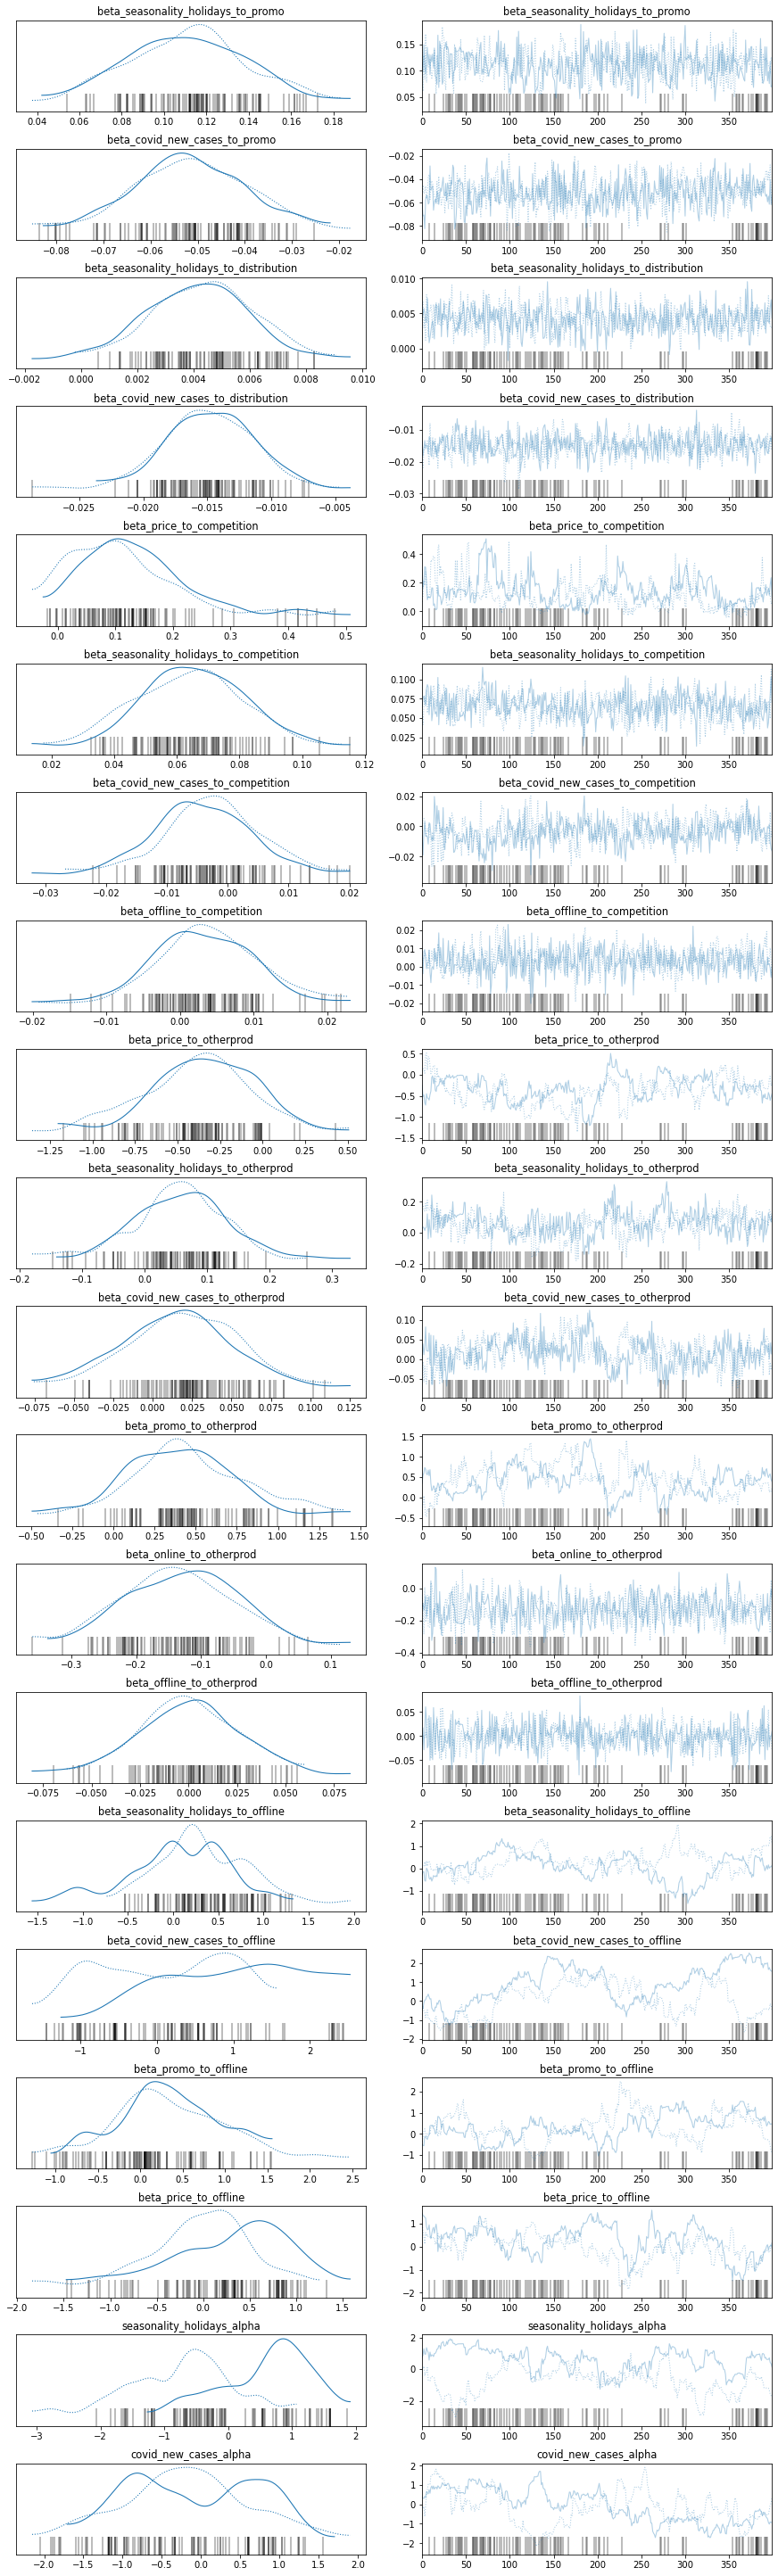

In [68]:
pm.traceplot(trace_dag)

#### 5.1.8 Posterior Predictive Check

array([[<AxesSubplot:xlabel='price / price'>,
        <AxesSubplot:xlabel='promo / promo'>,
        <AxesSubplot:xlabel='marketing_offline_old / marketing_offline_old'>,
        <AxesSubplot:xlabel='distribution / distribution'>],
       [<AxesSubplot:xlabel='marketing_online_old / marketing_online_old'>,
        <AxesSubplot:xlabel='other_products / other_products'>,
        <AxesSubplot:xlabel='competition / competition'>,
        <AxesSubplot:xlabel='tgt_pred / tgt_pred'>]], dtype=object)

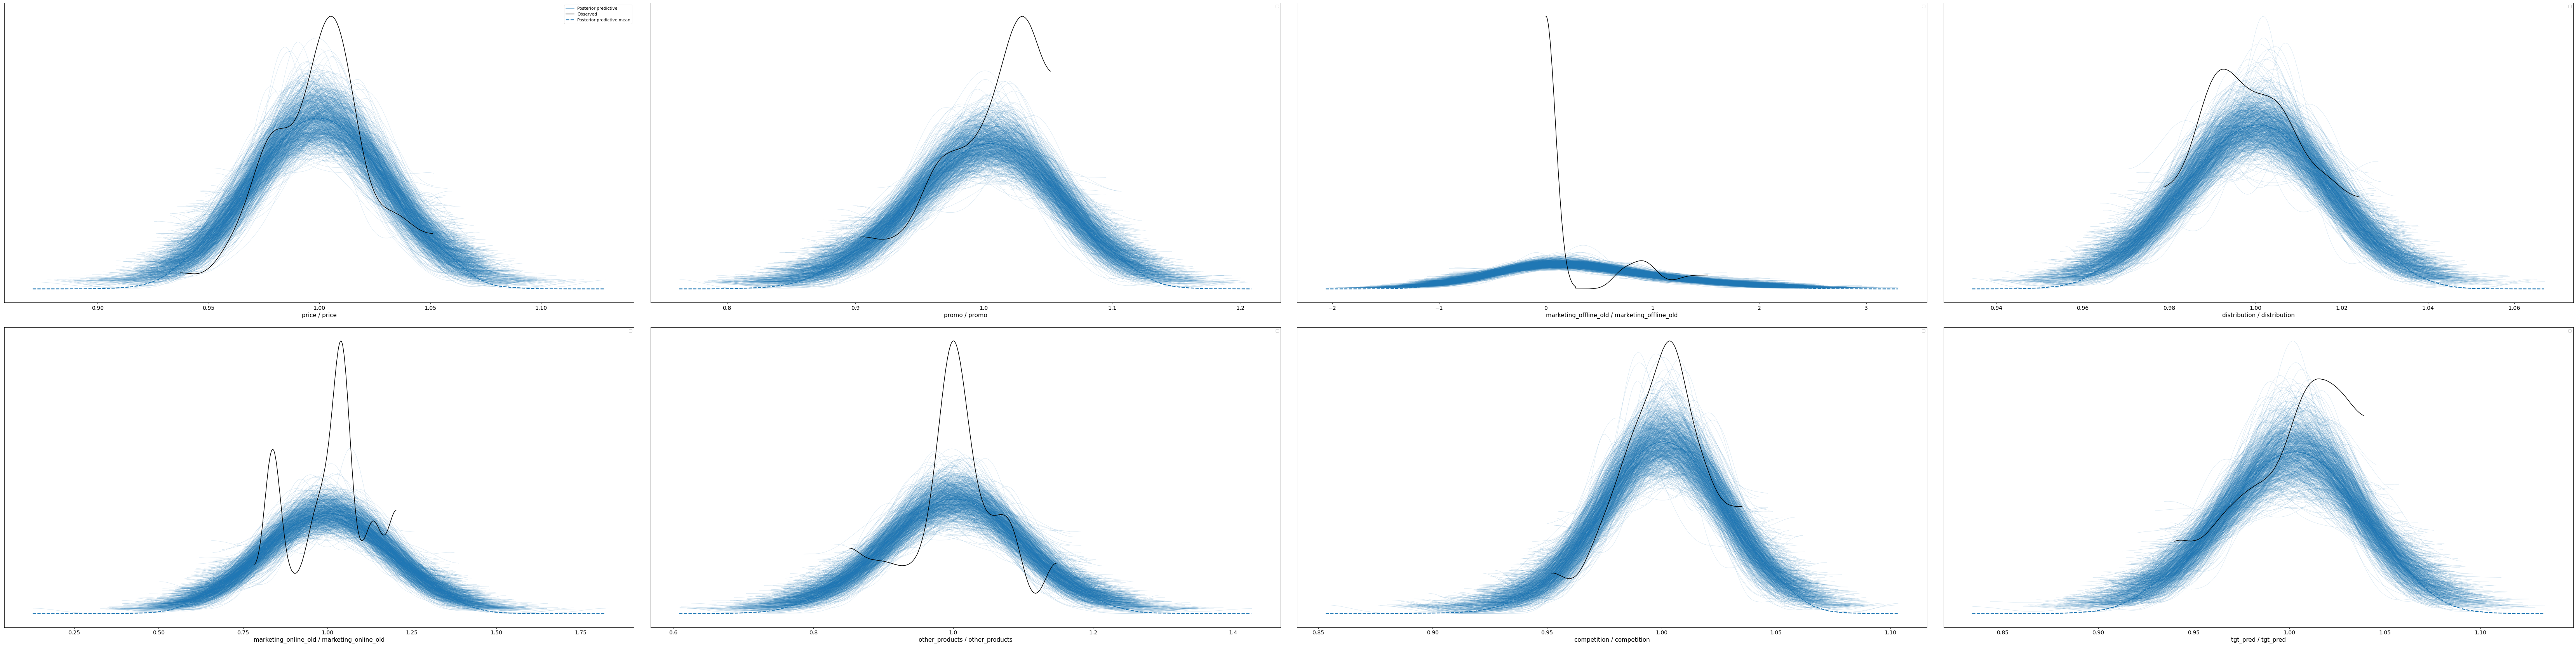

In [33]:
with py_stan_dag2:
    ppc = pm.sample_posterior_predictive(
        trace_dag,
        var_names=trace_dag.varnames + [
            'tgt_pred', 'other_products', 'promo', 'price', 'competition',
            'distribution', 'marketing_online_old', 'marketing_offline_old',
            'marketing_online', 'marketing_offline'
        ],
        random_seed=101)

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=py_stan_dag2))

#### 5.1.9 View Evaluation Metrics

In [69]:
print(az.waic(trace_dag, var_name="tgt_pred", scale='deviance'),
      az.loo(trace_dag, var_name="tgt_pred", scale='deviance'))

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 800 by 104 log-likelihood matrix

              Estimate       SE
deviance_waic  -804.72     2.60
p_waic           63.42        -

There has been a warning during the calculation. Please check the results. Computed from 800 by 104 log-likelihood matrix

             Estimate       SE
deviance_loo  -772.20     5.17
p_loo           79.68        -

There has been a warning during the calculation. Please check the results.


### 5.2 Change Priors

The original model was only weakly identified, since the given priors were consistent with all sorts of parameter values that did not make scientific sense. So I decided to take the time to specify more informative priors, and thus the original model was played as a default version that could be improved.

First, according to the plot in Section 5.1.3, some variables are not normally distributed. So we can change the distribution of variables in the model to their true distribution, like Normal to SkewNormal(Section 5.2.4).

Second, for interaction coefficients, after sampling from the original model without having any observed data(do not set the parameter ‘obs’, see Section 5.2.1), I modified mu and sigma of some interaction coefficients according to the summary statistics of the sampling (Section 5.2.3 and 5.2.4).

How well does it work? We can see from the prior predictive checks(Section 5.2.5). We have to admit that real-world data is really hard to perfectly simulate, but at least the modified model successfully makes the range of simulated tgt_pred narrow compared to the data simulated by the original model. Besides, if we compare the two models in terms of predictive ability, then the modified model is better, since the lower the metric is, the better the model will be(Section 5.2.8).

#### 5.2.1 Rebuild the original model without setting parameter 'Observed' 

In [34]:
%%time

with pm.Model() as py_stan_dag2_without_obs:

    ################################ Defining Mean & Sigma ################################
    len_df = len(data_dict['tgt'])
    seasonality_holidays_mean = mean_dict['seasonality_holidays_mean']
    covid_new_cases_mean = mean_dict['covid_new_cases_mean']
    seasonality_holidays_sigma = sigma_dict['seasonality_holidays_sigma']
    covid_new_cases_sigma = sigma_dict['covid_new_cases_sigma']
    price_mean = mean_dict['price_mean']
    price_sigma = sigma_dict['price_sigma']
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_offline_mean = mean_dict['marketing_offline_mean']
    promo_sigma = sigma_dict['promo_sigma']
    promo_mean = mean_dict['promo_mean']
    distribution_sigma = sigma_dict['distribution_sigma']
    distribution_mean = mean_dict['distribution_mean']
    competition_sigma = sigma_dict['competition_sigma']
    competition_mean = mean_dict['competition_mean']
    other_products_sigma = sigma_dict['other_products_sigma']
    other_products_mean = mean_dict['other_products_mean']
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    marketing_online_mean = mean_dict['marketing_online_mean']
    tgt_mean = mean_dict['tgt_mean']

    tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    ################################ Defining Beta's ################################
    BoundedNormal = pm.Bound(pm.Normal, upper=0)
    beta_price_to_promo = BoundedNormal('beta_price_to_promo', 0, 1)
    beta_seasonality_holidays_to_promo = pm.Normal(
        'beta_seasonality_holidays_to_promo', 0, 1)
    beta_covid_new_cases_to_promo = pm.Normal('beta_covid_new_cases_to_promo',
                                              0, 1)
    beta_offline_to_online = pm.HalfNormal('beta_offline_to_online', 1)
    beta_seasonality_holidays_to_online = BoundedNormal(
        'beta_seasonality_holidays_to_online', 0, 1)
    beta_covid_new_cases_to_online = BoundedNormal(
        'beta_covid_new_cases_to_online', 0, 1)
    beta_seasonality_holidays_to_distribution = pm.Normal(
        'beta_seasonality_holidays_to_distribution', 0, 1)
    beta_covid_new_cases_to_distribution = pm.Normal(
        'beta_covid_new_cases_to_distribution', 0, 1)
    beta_price_to_competition = pm.Normal('beta_price_to_competition', 0, 1)
    beta_seasonality_holidays_to_competition = pm.Normal(
        'beta_seasonality_holidays_to_competition', 0, 1)
    beta_covid_new_cases_to_competition = pm.Normal(
        'beta_covid_new_cases_to_competition', 0, 1)
    beta_promo_to_competition = BoundedNormal('beta_promo_to_competition', 0,
                                              1)
    beta_online_to_competition = BoundedNormal('beta_online_to_competition', 0,
                                               1)
    beta_distribution_to_competition = BoundedNormal(
        'beta_distribution_to_competition', 0, 1)
    beta_offline_to_competition = pm.Normal('beta_offline_to_competition', 0,
                                            1)
    beta_price_to_otherprod = pm.Normal('beta_price_to_otherprod', 0, 1)
    beta_seasonality_holidays_to_otherprod = pm.Normal(
        'beta_seasonality_holidays_to_otherprod', 0, 1)
    beta_covid_new_cases_to_otherprod = pm.Normal(
        'beta_covid_new_cases_to_otherprod', 0, 1)
    beta_promo_to_otherprod = pm.Normal('beta_promo_to_otherprod', 0, 1)
    beta_online_to_otherprod = pm.Normal('beta_online_to_otherprod', 0, 1)
    beta_offline_to_otherprod = pm.Normal('beta_offline_to_otherprod', 0, 1)
    beta_seasonality_holidays_to_offline = pm.Normal(
        'beta_seasonality_holidays_to_offline', 0, 1)
    beta_covid_new_cases_to_offline = pm.Normal(
        'beta_covid_new_cases_to_offline', 0, 1)
    beta_promo_to_offline = pm.Normal('beta_promo_to_offline', 0, 1)
    beta_price_to_offline = pm.Normal('beta_price_to_offline', 0, 1)
    beta_seasonality_holidays_to_tgt = BoundedNormal(
        'beta_seasonality_holidays_to_tgt', 0, 1)
    beta_covid_new_cases_to_tgt = BoundedNormal('beta_covid_new_cases_to_tgt',
                                                0, 1)
    beta_distribution_to_tgt = pm.HalfNormal('beta_distribution_to_tgt', 1)
    beta_competition_to_tgt = BoundedNormal('beta_competition_to_tgt', 0, 1)
    beta_online_to_tgt = pm.HalfNormal('beta_online_to_tgt', 1)
    beta_price_to_tgt = BoundedNormal('beta_price_to_tgt', 0, 1)
    beta_promo_to_tgt = pm.HalfNormal('beta_promo_to_tgt', 1)
    beta_otherprod_to_tgt = pm.HalfNormal('beta_otherprod_to_tgt', 1)
    beta_offline_to_tgt = pm.HalfNormal('beta_offline_to_tgt', 1)

    seasonality_holidays_alpha = pm.Normal('seasonality_holidays_alpha', 0, 1)
    covid_new_cases_alpha = pm.Normal('covid_new_cases_alpha', 0, 1)
    promo_mu = pm.Normal('promo_mu',
                         promo_mean,
                         sigma=promo_sigma,
                         shape=len_df)
    price_mu = pm.Normal('price_mu',
                         price_mean,
                         sigma=price_sigma,
                         shape=len_df)
    marketing_online_mu = pm.Normal('marketing_online_mu',
                                    marketing_online_mean,
                                    sigma=2 * marketing_online_sigma,
                                    shape=len_df)
    distribution_mu = pm.Normal('distribution_mu',
                                distribution_mean,
                                sigma=distribution_sigma,
                                shape=len_df)
    marketing_offline_mu = pm.Normal('marketing_offline_mu',
                                     marketing_offline_mean,
                                     sigma=marketing_offline_sigma,
                                     shape=len_df)
    other_products_mu = pm.Normal('other_products_mu',
                                  other_products_mean,
                                  sigma=other_products_sigma,
                                  shape=len_df)
    competition_mu = pm.Normal('competition_mu',
                               competition_mean,
                               sigma=competition_sigma,
                               shape=len_df)
    tgt_mu = pm.Normal('tgt_mu',
                       tgt_mean,
                       sigma=sigma_dict['tgt_sigma'],
                       shape=len_df)

    beta_online = pm.Deterministic(
        f'beta_online_spend',
        tt.switch(tt.eq(data2['MARKETING_ONLINE_SP'].values, 0), 0, 1))
    beta_offline = pm.Deterministic(
        f'beta_offline_spend',
        tt.switch(tt.eq(data2['MARKETING_OFFLINE_SP'].values, 0), 0, 1))
    ################################### Defining Adstock media ################################
    #Offline Adstock
    alpha_offline = pm.Beta('alpha_offline', 6, 6)  # retain rate in adstock
    #     alpha_offline = pm.Beta('alpha_offline',           3, 3)  # retain rate in adstock
    theta_offline = pm.Uniform('theta_offline', 0, 1.5)  # delay in adstock
    """marketing_offline_adstock=pm.Deterministic('marketing_offline_adstock',geometric_adstock(x=df_transformed['MARKETING_OFFLINE'].values,
                                                   theta=theta_offline,alpha=alpha_offline, L=4))"""
    #Online Adstock
    alpha_online = pm.Beta('alpha_online', 3, 3)  # retain rate in adstock
    theta_online = pm.Uniform('theta_online', 0, 0.5)  # delay in adstock
    """marketing_online_adstock=pm.Deterministic('marketing_online_adstock',geometric_adstock(x=df_transformed['MARKETING_ONLINE'].values,
                                                   theta=theta_online,alpha=alpha_online, L=2))"""

    ################################### parent nodes ################################
    seasonality_holidays_mu = pm.Normal('seasonality_holidays_mu',
                                        seasonality_holidays_mean,
                                        sigma=seasonality_holidays_sigma,
                                        shape=len_df)
    covid_new_cases_mu = pm.Normal('covid_new_cases_mu',
                                   covid_new_cases_mean,
                                   sigma=covid_new_cases_sigma,
                                   shape=len_df)

    seasonality_holidays = data_dict['seasonality_holidays']
    covid_new_cases = data_dict['covid_new_cases']

    price = pm.Normal('price', price_mu, sigma=price_sigma, shape=len_df)

    ################################### Child nodes ################################

    promo = pm.Normal(
        'promo',
        promo_mu + beta_price_to_promo * price +
        beta_seasonality_holidays_to_promo * seasonality_holidays +
        beta_covid_new_cases_to_promo * covid_new_cases,
        sigma=promo_sigma,
        shape=len_df)

    marketing_offline_old = pm.Normal(
        'marketing_offline_old',
        beta_offline *
        (marketing_offline_mu +
         beta_seasonality_holidays_to_offline * seasonality_holidays +
         beta_covid_new_cases_to_offline * covid_new_cases +
         beta_promo_to_offline * promo + beta_price_to_offline * price),
        sigma=marketing_offline_sigma,
        shape=len_df)

    marketing_offline = pm.Deterministic(
        'marketing_offline',
        geometric_adstock(x=marketing_offline_old,
                          theta=theta_offline,
                          alpha=alpha_offline,
                          L=4))

    distribution = pm.Normal(
        'distribution',
        distribution_mu +
        beta_seasonality_holidays_to_distribution * seasonality_holidays +
        beta_covid_new_cases_to_distribution * covid_new_cases,
        sigma=distribution_sigma,
        shape=len_df)

    marketing_online_old = pm.Normal(
        'marketing_online_old',
        beta_online *
        (marketing_online_mu + beta_offline_to_online * marketing_offline +
         beta_seasonality_holidays_to_online * seasonality_holidays +
         beta_covid_new_cases_to_online * covid_new_cases),
        sigma=marketing_online_sigma,
        shape=len_df)
    marketing_online = pm.Deterministic(
        'marketing_online',
        geometric_adstock(x=marketing_online_old,
                          theta=theta_online,
                          alpha=alpha_online,
                          L=2))

    other_products = pm.Normal(
        'other_products',
        other_products_mu + beta_price_to_otherprod * price +
        beta_seasonality_holidays_to_otherprod * seasonality_holidays +
        beta_covid_new_cases_to_otherprod * covid_new_cases +
        beta_promo_to_otherprod * promo +
        beta_offline_to_otherprod * marketing_offline +
        beta_online_to_otherprod * marketing_online,
        sigma=other_products_sigma,
        shape=len_df)

    competition = pm.Normal(
        'competition',
        competition_mu + beta_price_to_competition * price +
        beta_seasonality_holidays_to_competition * seasonality_holidays +
        beta_covid_new_cases_to_competition * covid_new_cases +
        beta_promo_to_competition * promo +
        beta_online_to_competition * marketing_online +
        beta_distribution_to_competition * distribution +
        beta_offline_to_competition * marketing_offline,
        sigma=competition_sigma,
        shape=len_df)

    ################################### Prediction ################################
    y = pm.Normal(
        'tgt_pred',
        tgt_mu + beta_seasonality_holidays_to_tgt * seasonality_holidays +
        beta_covid_new_cases_to_tgt * covid_new_cases +
        beta_distribution_to_tgt * distribution +
        beta_competition_to_tgt * competition +
        beta_offline_to_tgt * marketing_offline + beta_price_to_tgt * price +
        beta_promo_to_tgt * promo + beta_otherprod_to_tgt * other_products +
        beta_online_to_tgt * marketing_online,
        sigma=tgt_sigma,
        shape=len_df)

CPU times: user 5.69 s, sys: 90.6 ms, total: 5.78 s
Wall time: 5.85 s


#### 5.2.2 Sampling

In [35]:
%%time
with py_stan_dag2_without_obs:
    # sample using the model
    step = pm.NUTS(target_accept=0.9)
    trace_dag_without_obs = pm.sample(400,
                                      tune=100,
                                      step=step,
                                      chains=2,
                                      return_inferencedata=False,
                                      random_seed=101,
                                      cores=4)

Only 400 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tgt_pred, competition, other_products, marketing_online_old, distribution, marketing_offline_old, promo, price, covid_new_cases_mu, seasonality_holidays_mu, theta_online, alpha_online, theta_offline, alpha_offline, tgt_mu, competition_mu, other_products_mu, marketing_offline_mu, distribution_mu, marketing_online_mu, price_mu, promo_mu, covid_new_cases_alpha, seasonality_holidays_alpha, beta_offline_to_tgt, beta_otherprod_to_tgt, beta_promo_to_tgt, beta_price_to_tgt, beta_online_to_tgt, beta_competition_to_tgt, beta_distribution_to_tgt, beta_covid_new_cases_to_tgt, beta_seasonality_holidays_to_tgt, beta_price_to_offline, beta_promo_to_offline, beta_covid_new_cases_to_offline, beta_seasonality_holidays_to_offline, beta_offline_to_otherprod, beta_online_to_otherprod, beta_promo_to_otherprod, beta_covid_new_cases_to_otherprod, beta_seasonality_holidays_to_otherprod, beta_price_to_otherprod, beta_offline_to_competi

Sampling 2 chains for 100 tune and 400 draw iterations (200 + 800 draws total) took 502 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 42.1 s, sys: 2.45 s, total: 44.6 s
Wall time: 9min 2s


#### 5.2.3 Viewing summary statistics

In [36]:
pm.summary(trace_dag_without_obs)

Got error No model on context stack. trying to find log_likelihood in translation.
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  \
beta_seasonality_holidays_to_promo        -0.267  0.488  -1.189    0.547   
beta_covid_new_cases_to_promo             -0.104  0.415  -0.886    0.524   
beta_seasonality_holidays_to_distribution  0.284  0.467  -0.481    1.098   
beta_covid_new_cases_to_distribution      -0.268  0.492  -1.133    0.629   
beta_price_to_competition                 -0.075  0.790  -1.550    1.452   
beta_seasonality_holidays_to_competition   0.305  0.856  -0.998    1.964   
beta_covid_new_cases_to_competition       -0.105  0.833  -1.397    1.740   
beta_offline_to_competition               -0.808  0.802  -2.350    0.422   
beta_price_to_otherprod                   -0.427  0.723  -1.692    0.989   
beta_seasonality_holidays_to_otherprod    -0.003  0.672  -1.340    1.199   
beta_covid_new_cases_to_otherprod         -0.782  0.802  -2.414    0.430   
beta_promo_to_otherprod                   -0.384  0.812  -1.833    1.021   
beta_online_to_otherprod                   0.017  0.712  -1.362    1.106   
beta_offline_to_otherprod                  0.210  0.823  -1.464    1.930   
beta_seasonality_holidays_to_offline      -0.163  0.684  -1.481    0.961   
beta_covid_new_cases_to_offline            0.015  0.972  -1.802    1.773   
beta_promo_to_offline                     -0.185  0.913  -1.775    1.676   
beta_price_to_offline                     -0.182  0.576  -1.240    0.836   
seasonality_holidays_alpha                -0.009  1.142  -2.212    1.983   
covid_new_cases_alpha                      0.136  1.059  -1.830    2.432   
promo_mu[0]                                1.000  0.037   0.926    1.063   
promo_mu[1]                                1.002  0.037   0.939    1.075   
promo_mu[2]                                1.001  0.035   0.941    1.068   
promo_mu[3]                                1.000  0.039   0.934    1.077   
promo_mu[4]                                0.999  0.037   0.931    1.069   
promo_mu[5]                                1.000  0.038   0.928    1.072   
promo_mu[6]                                0.999  0.036   0.932    1.068   
promo_mu[7]                                1.000  0.038   0.928    1.069   
promo_mu[8]                                0.998  0.036   0.923    1.058   
promo_mu[9]                                1.001  0.037   0.928    1.069   
promo_mu[10]                               0.998  0.037   0.929    1.068   
promo_mu[11]                               0.998  0.036   0.938    1.065   
promo_mu[12]                               1.000  0.038   0.924    1.067   
promo_mu[13]                               1.001  0.037   0.929    1.067   
promo_mu[14]                               1.002  0.038   0.932    1.068   
promo_mu[15]                               1.000  0.038   0.929    1.069   
promo_mu[16]                               1.001  0.037   0.926    1.061   
promo_mu[17]                               0.998  0.039   0.926    1.071   
promo_mu[18]                               1.000  0.037   0.929    1.066   
promo_mu[19]                               1.001  0.037   0.924    1.064   
promo_mu[20]                               0.997  0.038   0.923    1.071   
promo_mu[21]                               0.999  0.038   0.928    1.070   
promo_mu[22]                               1.000  0.037   0.931    1.072   
promo_mu[23]                               1.000  0.035   0.934    1.064   
promo_mu[24]                               0.999  0.035   0.932    1.062   
promo_mu[25]                               1.001  0.036   0.938    1.074   
promo_mu[26]                               1.000  0.037   0.928    1.069   
promo_mu[27]                               0.999  0.035   0.929    1.062   
promo_mu[28]                               1.001  0.039   0.928    1.073   
promo_mu[29]                               0.999  0.039   0.930    1.078   
promo_mu[30]                               1.000  0.036   0.941    1.073   
promo_mu[31]                               1.000  0.036   0.934    1.067   
promo_mu[32]    

#### 5.2.4 Change mu and sigma of distribution of coefficients in the model according to the pm.summary result above, and then change distribution of variables in the model according to the true distribution of variables in the dataset. 

In [37]:
%%time

with pm.Model() as model_change_priors:

    ################################ Defining Mean & Sigma ################################
    len_df = len(data_dict['tgt'])
    seasonality_holidays_mean = mean_dict['seasonality_holidays_mean']
    covid_new_cases_mean = mean_dict['covid_new_cases_mean']
    seasonality_holidays_sigma = sigma_dict['seasonality_holidays_sigma']
    covid_new_cases_sigma = sigma_dict['covid_new_cases_sigma']
    price_mean = mean_dict['price_mean']
    price_sigma = sigma_dict['price_sigma']
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_offline_mean = mean_dict['marketing_offline_mean']
    promo_sigma = sigma_dict['promo_sigma']
    promo_mean = mean_dict['promo_mean']
    distribution_sigma = sigma_dict['distribution_sigma']
    distribution_mean = mean_dict['distribution_mean']
    competition_sigma = sigma_dict['competition_sigma']
    competition_mean = mean_dict['competition_mean']
    other_products_sigma = sigma_dict['other_products_sigma']
    other_products_mean = mean_dict['other_products_mean']
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    marketing_online_mean = mean_dict['marketing_online_mean']
    tgt_mean = mean_dict['tgt_mean']

    tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    ################################ Defining Beta's ################################
    BoundedNormal = pm.Bound(pm.Normal, upper=0)
    beta_price_to_promo = BoundedNormal('beta_price_to_promo', -0.8, 0.5)
    beta_seasonality_holidays_to_promo = pm.Normal(
        'beta_seasonality_holidays_to_promo', -0.3, 0.5)
    beta_covid_new_cases_to_promo = pm.Normal('beta_covid_new_cases_to_promo',
                                              0, 0.5)
    beta_offline_to_online = pm.HalfNormal('beta_offline_to_online', 0.5)
    beta_seasonality_holidays_to_online = BoundedNormal(
        'beta_seasonality_holidays_to_online', -0.7, 0.5)
    beta_covid_new_cases_to_online = BoundedNormal(
        'beta_covid_new_cases_to_online', -0.6, 0.5)
    beta_seasonality_holidays_to_distribution = pm.Normal(
        'beta_seasonality_holidays_to_distribution', 0.3, 0.5)
    beta_covid_new_cases_to_distribution = pm.Normal(
        'beta_covid_new_cases_to_distribution', -0.3, 0.5)
    beta_price_to_competition = pm.Normal('beta_price_to_competition', 0, 0.8)
    beta_seasonality_holidays_to_competition = pm.Normal(
        'beta_seasonality_holidays_to_competition', 0.3, 0.85)
    beta_covid_new_cases_to_competition = pm.Normal(
        'beta_covid_new_cases_to_competition', 0, 0.83)
    beta_promo_to_competition = BoundedNormal('beta_promo_to_competition',
                                              -0.8, 0.6)
    beta_online_to_competition = BoundedNormal('beta_online_to_competition',
                                               -0.75, 0.6)
    beta_distribution_to_competition = BoundedNormal(
        'beta_distribution_to_competition', -0.6, 0.5)
    beta_offline_to_competition = pm.Normal('beta_offline_to_competition',
                                            -0.8, 0.8)
    beta_price_to_otherprod = pm.Normal('beta_price_to_otherprod', -0.4, 0.7)
    beta_seasonality_holidays_to_otherprod = pm.Normal(
        'beta_seasonality_holidays_to_otherprod', 0, 0.7)
    beta_covid_new_cases_to_otherprod = pm.Normal(
        'beta_covid_new_cases_to_otherprod', -0.8, 0.8)
    beta_promo_to_otherprod = pm.Normal('beta_promo_to_otherprod', -0.4, 0.8)
    beta_online_to_otherprod = pm.Normal('beta_online_to_otherprod', 0, 0.7)
    beta_offline_to_otherprod = pm.Normal('beta_offline_to_otherprod', 0.2,
                                          0.8)
    beta_seasonality_holidays_to_offline = pm.Normal(
        'beta_seasonality_holidays_to_offline', -0.15, 0.7)
    beta_covid_new_cases_to_offline = pm.Normal(
        'beta_covid_new_cases_to_offline', 0, 1)
    beta_promo_to_offline = pm.Normal('beta_promo_to_offline', -0.2, 0.9)
    beta_price_to_offline = pm.Normal('beta_price_to_offline', -0.2, 0.6)
    beta_seasonality_holidays_to_tgt = BoundedNormal(
        'beta_seasonality_holidays_to_tgt', -0.8, 0.5)
    beta_covid_new_cases_to_tgt = BoundedNormal('beta_covid_new_cases_to_tgt',
                                                -0.6, 0.55)
    beta_distribution_to_tgt = pm.HalfNormal('beta_distribution_to_tgt', 0.5)
    beta_competition_to_tgt = BoundedNormal('beta_competition_to_tgt', -0.85,
                                            0.65)
    beta_online_to_tgt = pm.HalfNormal('beta_online_to_tgt', 0.7)
    beta_price_to_tgt = BoundedNormal('beta_price_to_tgt', -0.7, 0.5)
    beta_promo_to_tgt = pm.HalfNormal('beta_promo_to_tgt', 0.6)
    beta_otherprod_to_tgt = pm.HalfNormal('beta_otherprod_to_tgt', 0.6)
    beta_offline_to_tgt = pm.HalfNormal('beta_offline_to_tgt', 0.7)

    seasonality_holidays_alpha = pm.Normal('seasonality_holidays_alpha', 0,
                                           1.5)
    covid_new_cases_alpha = pm.Normal('covid_new_cases_alpha', 0, 1)
    promo_mu = pm.Normal('promo_mu',
                         promo_mean,
                         sigma=promo_sigma,
                         shape=len_df)
    price_mu = pm.Normal('price_mu',
                         price_mean,
                         sigma=price_sigma,
                         shape=len_df)
    marketing_online_mu = pm.Normal('marketing_online_mu',
                                    marketing_online_mean,
                                    sigma=2 * marketing_online_sigma,
                                    shape=len_df)
    distribution_mu = pm.Normal('distribution_mu',
                                distribution_mean,
                                sigma=distribution_sigma,
                                shape=len_df)
    marketing_offline_mu = pm.Normal('marketing_offline_mu',
                                     marketing_offline_mean,
                                     sigma=marketing_offline_sigma,
                                     shape=len_df)
    other_products_mu = pm.Normal('other_products_mu',
                                  other_products_mean,
                                  sigma=other_products_sigma,
                                  shape=len_df)
    competition_mu = pm.Normal('competition_mu',
                               competition_mean,
                               sigma=competition_sigma,
                               shape=len_df)
    tgt_mu = pm.Normal('tgt_mu',
                       tgt_mean,
                       sigma=sigma_dict['tgt_sigma'],
                       shape=len_df)

    beta_online = pm.Deterministic(
        f'beta_online_spend',
        tt.switch(tt.eq(data2['MARKETING_ONLINE_SP'].values, 0), 0, 1))
    beta_offline = pm.Deterministic(
        f'beta_offline_spend',
        tt.switch(tt.eq(data2['MARKETING_OFFLINE_SP'].values, 0), 0, 1))
    ################################### Defining Adstock media ################################
    #Offline Adstock
    alpha_offline = pm.Beta('alpha_offline', 6, 6)  # retain rate in adstock
    #     alpha_offline = pm.Beta('alpha_offline',           3, 3)  # retain rate in adstock
    theta_offline = pm.Uniform('theta_offline', 0, 1.5)  # delay in adstock
    """marketing_offline_adstock=pm.Deterministic('marketing_offline_adstock',geometric_adstock(x=df_transformed['MARKETING_OFFLINE'].values,
                                                   theta=theta_offline,alpha=alpha_offline, L=4))"""
    #Online Adstock
    alpha_online = pm.Beta('alpha_online', 3, 3)  # retain rate in adstock
    theta_online = pm.Uniform('theta_online', 0, 0.5)  # delay in adstock
    """marketing_online_adstock=pm.Deterministic('marketing_online_adstock',geometric_adstock(x=df_transformed['MARKETING_ONLINE'].values,
                                                   theta=theta_online,alpha=alpha_online, L=2))"""

    ################################### parent nodes ################################
    seasonality_holidays_mu = pm.Normal('seasonality_holidays_mu',
                                        seasonality_holidays_mean,
                                        sigma=seasonality_holidays_sigma,
                                        shape=len_df)

    covid_new_cases_mu = pm.Normal('covid_new_cases_mu',
                                   covid_new_cases_mean,
                                   sigma=covid_new_cases_sigma,
                                   shape=len_df)

    seasonality_holidays = pm.SkewNormal(
        'seasonality_holidays',
        mu=seasonality_holidays_alpha + seasonality_holidays_mu,
        sigma=seasonality_holidays_sigma,
        alpha=1,
        shape=len_df,
        observed=data_dict['seasonality_holidays'])

    covid_new_cases = pm.Bernoulli('covid_new_cases',
                                   p=logistic(covid_new_cases_alpha +
                                              covid_new_cases_mu),
                                   shape=len_df,
                                   observed=data_dict['covid_new_cases'])

    price = pm.Normal('price',
                      price_mu,
                      sigma=price_sigma,
                      shape=len_df,
                      observed=data_dict['price'])

    ################################### Child nodes ################################

    promo = pm.SkewNormal(
        'promo',
        mu=promo_mu + beta_price_to_promo * price +
        beta_seasonality_holidays_to_promo * seasonality_holidays +
        beta_covid_new_cases_to_promo * covid_new_cases,
        sigma=promo_sigma,
        alpha=1,
        shape=len_df,
        observed=data_dict['promo'])

    marketing_offline_old = pm.Normal(
        'marketing_offline_old',
        beta_offline *
        (marketing_offline_mu +
         beta_seasonality_holidays_to_offline * seasonality_holidays +
         beta_covid_new_cases_to_offline * covid_new_cases +
         beta_promo_to_offline * promo + beta_price_to_offline * price),
        sigma=marketing_offline_sigma,
        shape=len_df,
        observed=data_dict['marketing_offline'])

    marketing_offline = pm.Deterministic(
        'marketing_offline',
        geometric_adstock(x=marketing_offline_old,
                          theta=theta_offline,
                          alpha=alpha_offline,
                          L=4))

    distribution = pm.SkewNormal(
        'distribution',
        mu=distribution_mu +
        beta_seasonality_holidays_to_distribution * seasonality_holidays +
        beta_covid_new_cases_to_distribution * covid_new_cases,
        sigma=distribution_sigma,
        alpha=-1,
        shape=len_df,
        observed=data_dict['distribution'])

    marketing_online_old = pm.Normal(
        'marketing_online_old',
        beta_online *
        (marketing_online_mu + beta_offline_to_online * marketing_offline +
         beta_seasonality_holidays_to_online * seasonality_holidays +
         beta_covid_new_cases_to_online * covid_new_cases),
        sigma=marketing_online_sigma,
        shape=len_df,
        observed=data_dict['marketing_online'])
    marketing_online = pm.Deterministic(
        'marketing_online',
        geometric_adstock(x=marketing_online_old,
                          theta=theta_online,
                          alpha=alpha_online,
                          L=2))

    other_products = pm.Normal(
        'other_products',
        other_products_mu + beta_price_to_otherprod * price +
        beta_seasonality_holidays_to_otherprod * seasonality_holidays +
        beta_covid_new_cases_to_otherprod * covid_new_cases +
        beta_promo_to_otherprod * promo +
        beta_offline_to_otherprod * marketing_offline +
        beta_online_to_otherprod * marketing_online,
        sigma=other_products_sigma,
        shape=len_df,
        observed=data_dict['other_products'])

    competition = pm.SkewNormal(
        'competition',
        mu=competition_mu + beta_price_to_competition * price +
        beta_seasonality_holidays_to_competition * seasonality_holidays +
        beta_covid_new_cases_to_competition * covid_new_cases +
        beta_promo_to_competition * promo +
        beta_online_to_competition * marketing_online +
        beta_distribution_to_competition * distribution +
        beta_offline_to_competition * marketing_offline,
        sigma=competition_sigma,
        alpha=1,
        shape=len_df,
        observed=data_dict['competition'])

    ################################### Prediction ################################
    y = pm.SkewNormal(
        'tgt_pred',
        tgt_mu + beta_seasonality_holidays_to_tgt * seasonality_holidays +
        beta_covid_new_cases_to_tgt * covid_new_cases +
        beta_distribution_to_tgt * distribution +
        beta_competition_to_tgt * competition +
        beta_offline_to_tgt * marketing_offline + beta_price_to_tgt * price +
        beta_promo_to_tgt * promo + beta_otherprod_to_tgt * other_products +
        beta_online_to_tgt * marketing_online,
        sigma=tgt_sigma,
        alpha=1,
        observed=data_dict['tgt'])

CPU times: user 5.42 s, sys: 223 ms, total: 5.64 s
Wall time: 7.31 s


#### 5.2.5 Prior Predictive Check

In [25]:
sim_from_modified_model = pm.sample_prior_predictive(samples=400,
                                                     model=model_change_priors,
                                                     random_seed=101)

In [26]:
tgt_pred_sim_from_modified_model = []
for i in sim_from_modified_model['tgt_pred'][0]:
    for j in i:
        tgt_pred_sim_from_modified_model.append(j)

c = {"simulated tgt_pred": tgt_pred_sim_from_modified_model}
df_sim1 = pd.DataFrame(c)
df_sim1.describe()

simulated tgt_pred
count        41600.000000
mean            -0.979022
std              3.082514
min            -16.674121
25%             -2.604502
50%             -0.803343
75%              0.906976
max             23.459498

In [27]:
df_transformed['TGT'].describe()

count    104.000000
mean       1.000000
std        0.026095
min        0.939898
25%        0.980606
50%        1.006009
75%        1.021171
max        1.038779
Name: TGT, dtype: float64

#### 5.2.6 Sampling

In [38]:
%%time
with model_change_priors:
    # sample using the model
    step = pm.NUTS(target_accept=0.9)
    trace_model_change_priors = pm.sample(400,
                                          tune=100,
                                          step=step,
                                          chains=2,
                                          return_inferencedata=False,
                                          random_seed=101,
                                          cores=4)

Only 400 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [covid_new_cases_mu, seasonality_holidays_mu, theta_online, alpha_online, theta_offline, alpha_offline, tgt_mu, competition_mu, other_products_mu, marketing_offline_mu, distribution_mu, marketing_online_mu, price_mu, promo_mu, covid_new_cases_alpha, seasonality_holidays_alpha, beta_offline_to_tgt, beta_otherprod_to_tgt, beta_promo_to_tgt, beta_price_to_tgt, beta_online_to_tgt, beta_competition_to_tgt, beta_distribution_to_tgt, beta_covid_new_cases_to_tgt, beta_seasonality_holidays_to_tgt, beta_price_to_offline, beta_promo_to_offline, beta_covid_new_cases_to_offline, beta_seasonality_holidays_to_offline, beta_offline_to_otherprod, beta_online_to_otherprod, beta_promo_to_otherprod, beta_covid_new_cases_to_otherprod, beta_seasonality_holidays_to_otherprod, beta_price_to_otherprod, beta_offline_to_competition, beta_distribution_to_competition, beta_online_to_competition, beta_promo_to_competition, beta_covid_new_ca

Sampling 2 chains for 100 tune and 400 draw iterations (200 + 800 draws total) took 414 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7701501323008421, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 1min 13s, sys: 3.86 s, total: 1min 17s
Wall time: 8min 6s


#### 5.2.7 View Summary Statistics

In [39]:
pm.summary(trace_model_change_priors)

Got error No model on context stack. trying to find log_likelihood in translation.
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
//anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
//anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_var

mean     sd  hdi_3%  hdi_97%  \
beta_seasonality_holidays_to_promo         0.108  0.027   0.064    0.161   
beta_covid_new_cases_to_promo             -0.037  0.016  -0.065   -0.010   
beta_seasonality_holidays_to_distribution  0.008  0.002   0.005    0.011   
beta_covid_new_cases_to_distribution      -0.010  0.004  -0.020   -0.002   
beta_price_to_competition                  0.104  0.070  -0.010    0.238   
beta_seasonality_holidays_to_competition   0.059  0.015   0.035    0.088   
beta_covid_new_cases_to_competition       -0.001  0.009  -0.017    0.014   
beta_offline_to_competition                0.005  0.005  -0.006    0.014   
beta_price_to_otherprod                   -0.172  0.177  -0.522    0.165   
beta_seasonality_holidays_to_otherprod     0.096  0.055  -0.011    0.201   
beta_covid_new_cases_to_otherprod         -0.012  0.031  -0.065    0.057   
beta_promo_to_otherprod                    0.213  0.227  -0.262    0.597   
beta_online_to_otherprod                  -0.136  0.080  -0.272    0.008   
beta_offline_to_otherprod                  0.002  0.022  -0.039    0.038   
beta_seasonality_holidays_to_offline       0.232  0.555  -0.727    1.126   
beta_covid_new_cases_to_offline            0.724  0.806  -0.854    2.006   
beta_promo_to_offline                      0.549  0.447  -0.434    1.290   
beta_price_to_offline                     -0.103  0.442  -0.897    0.673   
seasonality_holidays_alpha                -0.088  0.020  -0.125   -0.049   
covid_new_cases_alpha                     -2.388  0.332  -2.869   -1.823   
promo_mu[0]                                1.001  0.021   0.964    1.045   
promo_mu[1]                                1.000  0.025   0.959    1.046   
promo_mu[2]                                1.009  0.022   0.966    1.049   
promo_mu[3]                                1.018  0.023   0.971    1.057   
promo_mu[4]                                1.013  0.024   0.966    1.056   
promo_mu[5]                                1.012  0.022   0.970    1.050   
promo_mu[6]                                1.022  0.030   0.977    1.081   
promo_mu[7]                                0.994  0.022   0.949    1.033   
promo_mu[8]                                1.002  0.025   0.952    1.045   
promo_mu[9]                                1.017  0.022   0.978    1.061   
promo_mu[10]                               1.017  0.023   0.968    1.055   
promo_mu[11]                               1.008  0.026   0.965    1.059   
promo_mu[12]                               1.009  0.021   0.963    1.047   
promo_mu[13]                               1.013  0.025   0.971    1.065   
promo_mu[14]                               1.009  0.023   0.968    1.052   
promo_mu[15]                               1.013  0.028   0.965    1.056   
promo_mu[16]                               1.021  0.023   0.979    1.063   
promo_mu[17]                               1.001  0.024   0.961    1.044   
promo_mu[18]                               1.006  0.029   0.961    1.055   
promo_mu[19]                               1.005  0.024   0.967    1.051   
promo_mu[20]                               1.008  0.023   0.965    1.050   
promo_mu[21]                               1.030  0.026   0.990    1.079   
promo_mu[22]                               1.014  0.025   0.971    1.065   
promo_mu[23]                               1.013  0.025   0.962    1.049   
promo_mu[24]                               1.005  0.021   0.962    1.044   
promo_mu[25]                               1.013  0.025   0.963    1.049   
promo_mu[26]                               1.001  0.023   0.963    1.043   
promo_mu[27]                               1.000  0.020   0.965    1.040   
promo_mu[28]                               1.006  0.020   0.971    1.047   
promo_mu[29]                               1.006  0.023   0.966    1.051   
promo_mu[30]                               1.011  0.022   0.973    1.057   
promo_mu[31]                               1.013  0.025   0.968    1.054   
promo_mu[32]    

#### 5.2.8 View Evaluation Metrics

In [25]:
print(
    az.waic(trace_model_change_priors, var_name="tgt_pred", scale='deviance'),
    az.loo(trace_model_change_priors, var_name="tgt_pred", scale='deviance'))

Got error No model on context stack. trying to find log_likelihood in translation.
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
Got error No model on context stack. trying to find log_likelihood in translation.
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future rel

Computed from 800 by 104 log-likelihood matrix

              Estimate       SE
deviance_waic  -843.12     2.84
p_waic           65.78        -

There has been a warning during the calculation. Please check the results. Computed from 800 by 104 log-likelihood matrix

             Estimate       SE
deviance_loo  -808.15     5.86
p_loo           83.27        -

There has been a warning during the calculation. Please check the results.


//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


## 6. Conclusions, Insights and Future

From the results we can know that, although the modified model still cannot perfectly simulate data that is similar to the real-world data, it successfully decreases the gap between real data and simulated data compared with the original model. Meanwhile, lower WAIC and LOO also indicates that it has a better predictive ability.

Due to the limitation of the tasks assigned to me, it’s hard to provide many really useful information about the business, but some insights can be obtained from interaction. For interaction priors, if we pick those with | mean | > 0.3 and std < 0.6, then we will get a table as following, where green refers to positive correlation and red refers to negative correlation. Meanwhile, the larger the circle is, the stronger the relationship is. 

Some correlations are quite obvious, so I am not going to explain all of them. However, two interesting ideas can indeed be pointed out. First, the company should launch more promotion activities, especially on holidays. Second, don't make the price too high. This seems obvious, but there are cases when companies might want to make the price higher, because they think higher price can make people think that their product is more valuable than others, and thus consumers who chase high quality would like to buy it. However, the result shows that this thought doesn't make sense.

For future work, continue finding better prior should be one of the most important things to do, since priors can affect result, and thus more domain knowledge can be considered into prior selection. 

In [4]:
%%html

# directed graph
<img src="./pictures/insights.png">